In [1]:
# import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
tf.random.set_seed(42)
np.random.seed(42)


import os
import sys

In [20]:
#idx = int(os.environ["SLURM_ARRAY_TASK_ID"])

#feature_setting = str(os.environ["Setting"])

#model_setting = str(os.environ["Model"])


"""
Define Parameter Configuration to Model

    Parameters
    ----------
    alpha : float, linear stiffness
    beta  : float, non linearity in the restoring force
    gamma : float, amplitude of the periodic driving force
    delta : float, amount of damping
    omega : float, angular frequency of the periodic driving force
"""   

parameter_list = [{'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}]



dict_param = parameter_list[0]

from Array_Submission_9.OtherFunctions import *
from  Array_Submission_9.BaseDuffing import Duffing

num_samples_ml = 1000


In [21]:
duffing = Duffing(parameters = dict_param)
eom = duffing.eom
#suffix = feature_setting + "_" + model_setting + "_" + duffing.suffix

end_time = 100
duffing.generate(num_samples_ml, samples = 100, end_time = end_time) #samples prev 100
duffing.scale_features()
X_train, X_test, y_train, y_test = train_test_split(duffing.X_df[duffing.features], 
                                                    duffing.X_df[duffing.labels], test_size=0.1, random_state=42)

X = X_test
y = y_test



histories = {}

Generating Data…: 100%|████████████████| 1000/1000 [00:29<00:00, 33.47it/s]


In [22]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [23]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]

for batch_size in [32, 64, 128, 256, 512, 1024, 2048]:
    print(batch_size)
    model = MLModel()

    history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, validation_split=0.2, 
                      batch_size=batch_size, shuffle=True, callbacks=callbacks, verbose=0)
    histories[str(batch_size)] = history
    #with open('Models/TrainingHistory/Model_batch_histories', 'wb') as file_pi:
    #    pickle.dump(histories, file_pi)

32
64
128
256
512
1024
2048


In [42]:
f, axs = plt.subplots(1, 1, figsize = (9,6), gridspec_kw = dict(width_ratios=[4]))
# evaluate the fitting validation and training losses
lines_ = [(6,2), (2,1), (8,5), (1,0), (3,3), (1,1), (5,5)]

for i, key in enumerate(histories):
    loss = histories[key].history['loss']
    val_loss = histories[key].history['val_loss']
    epochs = range(1, len(loss) + 1)
    axs.plot(epochs, histories[key].history['loss'], label=key, dashes = lines_[i])
    axs.plot(epochs, histories[key].history['val_loss'], dashes = lines_[i])

axs.set(xlim=(0, 40), ylim = (0.4, 0.55))
axs.set_xlabel('Epochs', fontsize = 20)
axs.set_ylabel('Loss', fontsize = 20)
#axs[0].set_title(r"Training Loss", fontsize = 14)
axs.legend(fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=14)
#f.suptitle(r"Validation Loss of the Complex Model by Epoch for Different Batch Sizes", fontsize = 16)

                      
f.tight_layout()
f.savefig("Images/BatchSize.svg", dpi='figure')

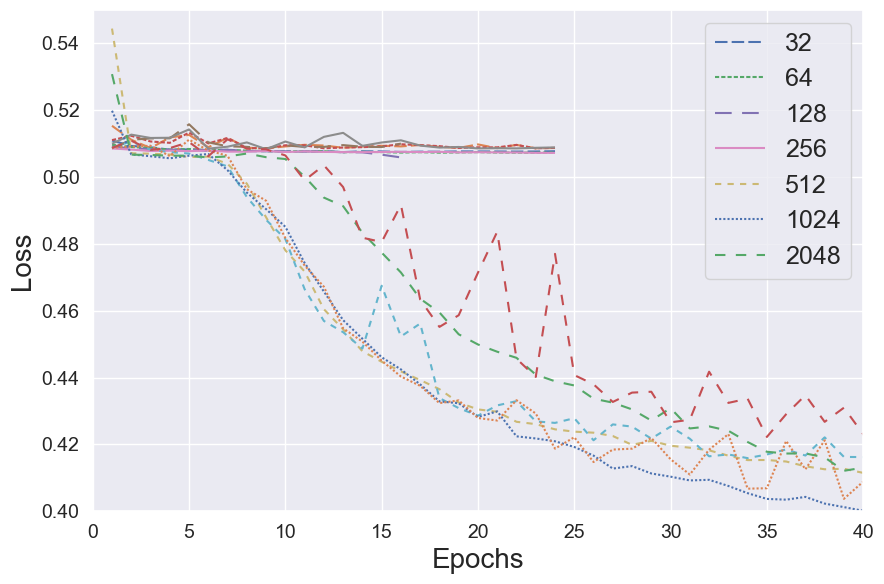

In [43]:
f